### Classifier models for predicting crime types

In [ ]:
!pip install pygeohash
# !pip install optuna
!pip install -U xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6168 sha256=30417aeea59d7061a34fc9f811cc0e8e6b1dda418776904f80a747b231d72cce
  Stored in directory: /root/.cache/pip/wheels/e2/ed/86/be7141d743cfb4aebac76406187154cd78fe9e6535d872187a
Successfully built pygeohash
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 37 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import numpy as np
import pandas as pd
import time
import pygeohash as pgh
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, top_k_accuracy_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
# import optuna
# optuna.logging.set_verbosity(optuna.logging.WARNING)
random_state = 0

In [ ]:
# load data
file_path = '/content/drive/MyDrive/Data/crimes_ext.csv'
start_time = time.time()
df = pd.read_csv(file_path, index_col=0)
print(f'{time.time() - start_time:.0f} seconds')
df.shape

55 seconds


(7001884, 22)

In [ ]:
df.drop_duplicates(keep='first', inplace=True)
df.shape

(6609619, 22)

In [ ]:
# use data from 2021
df = df[df['Year'] >= 2021]
df.shape

(393275, 22)

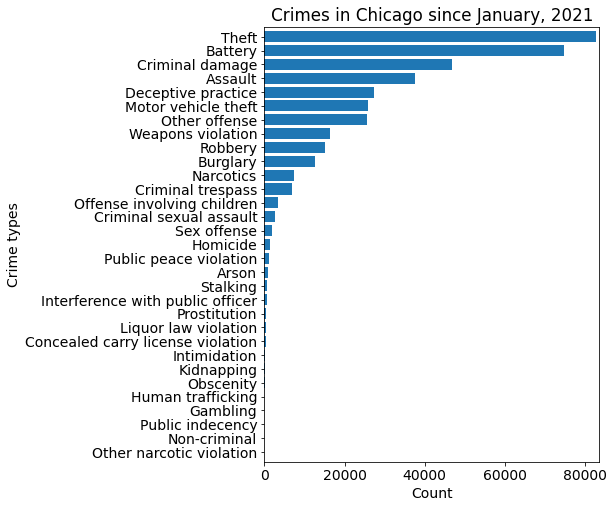

In [ ]:
# eda
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(6,8))
ax.barh(width=df['Primary Type'].value_counts(), y=df['Primary Type'].value_counts().index.str.capitalize())
ax.invert_yaxis()
ax.set(title='Crimes in Chicago since January, 2021', ylabel='Crime types', xlabel='Count')
ax.margins(0.01)
plt.show()

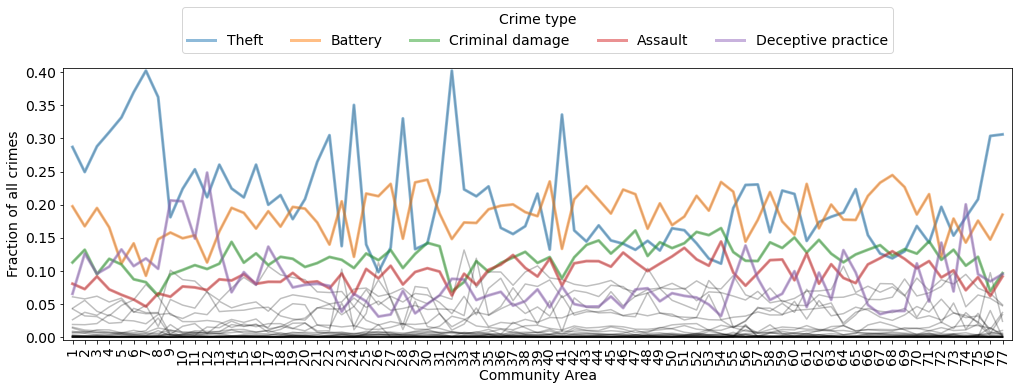

In [ ]:
tmp = df.copy().groupby(['Community Area', 'Primary Type']).count()['DateTime'].reset_index()
tmp['Primary Type'] = tmp['Primary Type'].str.capitalize()
tmpp = pd.pivot_table(data=tmp, columns=['Community Area'], index=['Primary Type'], values=['DateTime'], aggfunc='sum', fill_value=0)
tmpp.columns = [str(int(xx)) for xx in tmpp.columns.get_level_values(1)]
assert tmpp.sum().sum() == len(df)
tmpp = tmpp.div(tmpp.sum(axis=0), axis=1)

fig, ax = plt.subplots(figsize=(17,5))
for ii in tmpp.index:
  ax.plot(tmpp.columns, tmpp.loc[ii], alpha=0.25, c='k')
for ii in tmpp.sum(axis=1).nlargest(5).index:
  ax.plot(tmpp.columns, tmpp.loc[ii], lw=3, alpha=0.5, label=ii)
ax.legend(title='Crime type', loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5,)
ax.margins(0.01)
ax.tick_params(axis='x', labelrotation=90)
ax.set(ylabel='Fraction of all crimes', xlabel='Community Area')
plt.show()

In [ ]:
cols2keep = ['DateTime', 'Primary Type', 'Beat', 'Latitude', 'Longitude', 
             'C', 'm/s', 'PRCP', 'SNOW',
             'BullsGame', 'CubsGame', 'SoxGame', 'BearsGame', 
             'Holiday']
df1 = df[cols2keep].copy()
# drop rows
df1.dropna(subset=['Latitude', 'Longitude', 'DateTime', 'Primary Type'], inplace=True)
df1.rename(columns={'DateTime':'date', 'Primary Type':'type', 'Beat':'beat', 
                    'Latitude':'latitude', 'Longitude':'longitude',
                    'C':'temp', 'm/s':'wind', 'PRCP':'rain', 'SNOW':'snow',
                    'BullsGame':'bulls', 'CubsGame':'cubs', 'SoxGame':'sox', 'BearsGame':'bears',
                    'Holiday':'isholiday'}, inplace=True)
df1.shape

(393275, 14)

In [ ]:
start_time = time.time()
df1['date'] = pd.to_datetime(df1['date'])
print(f'{time.time() - start_time:.0f} seconds')

0 seconds


In [ ]:
df1 = df1.sample(frac=0.1, random_state=random_state)
df1.shape

(39328, 14)

In [ ]:
# time features
df1['month'] = df1['date'].dt.month
df1['day'] = df1['date'].dt.day
df1['hour'] = df1['date'].dt.round(freq='h').dt.hour 
df1['dayofweek'] = df1['date'].dt.dayofweek
df1['isday'] = (df1['hour'] > 5) & (df1['hour'] < 18)

In [ ]:
# space features
df1['geohash'] = df1.progress_apply(lambda x: pgh.encode(x['latitude'], x['longitude'], precision=6), axis=1)
cols2drop = ['latitude', 'longitude', 'date']
df1.drop(cols2drop, axis=1, inplace=True)

100%|██████████| 39328/39328 [00:01<00:00, 22758.15it/s]


In [ ]:
# consolidate categories
ss = (df1['type'].value_counts(normalize=True) < 0.001)
df1.loc[df1['type'].isin(ss[ss==1].index), 'type'] = 'OTHER OFFENSE'

In [ ]:
df1['type'].value_counts()

THEFT                               8296
BATTERY                             7463
CRIMINAL DAMAGE                     4641
ASSAULT                             3775
OTHER OFFENSE                       2771
DECEPTIVE PRACTICE                  2661
MOTOR VEHICLE THEFT                 2609
WEAPONS VIOLATION                   1586
ROBBERY                             1521
BURGLARY                            1257
NARCOTICS                            732
CRIMINAL TRESPASS                    683
OFFENSE INVOLVING CHILDREN           335
CRIMINAL SEXUAL ASSAULT              289
SEX OFFENSE                          191
HOMICIDE                             147
PUBLIC PEACE VIOLATION               136
ARSON                                 95
STALKING                              74
INTERFERENCE WITH PUBLIC OFFICER      66
Name: type, dtype: int64

In [ ]:
df1.reset_index(drop=True, inplace=True)
df1.nunique()

type           20
beat          274
temp          527
wind          208
rain           77
snow           31
bulls           2
cubs            2
sox             2
bears           2
isholiday       2
month          12
day            31
hour           24
dayofweek       7
isday           2
geohash      1056
dtype: int64

In [ ]:
bool_cols = ['bulls', 'cubs', 'sox', 'bears', 'isholiday', 'isday']
df1[bool_cols] = df1[bool_cols].astype(bool)
cat_cols = ['beat', 'month', 'day', 'hour', 'dayofweek', 'geohash']
df1[cat_cols] = df1[cat_cols].astype('category')
df1.dtypes

type           object
beat         category
temp          float64
wind          float64
rain          float64
snow          float64
bulls            bool
cubs             bool
sox              bool
bears            bool
isholiday        bool
month        category
day          category
hour         category
dayofweek    category
isday            bool
geohash      category
dtype: object

In [ ]:
# train test split
y = df1['type']
X = df1[[xx for xx in df1.columns if xx != 'type']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31462, 16), (31462,), (7866, 16), (7866,))

In [ ]:
# preprocess label
le = LabelEncoder().fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
# preprocess features
num_cols = ['temp', 'wind', 'rain', 'snow']
num_transformer = Pipeline(steps=[
    ('std', StandardScaler())
    ])

cat_cols = [xx for xx in df1.columns if xx not in num_cols and xx != 'type']
cat_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False))
    ])
print('num cols:', num_cols)
print('cat cols:', cat_cols)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
        ])

preprocessor.fit(X_train, y_train)
X_train_enc = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=preprocessor.get_feature_names_out())
X_test_enc = pd.DataFrame(preprocessor.transform(X_test), index=X_test.index, columns=preprocessor.get_feature_names_out())
X_train_enc.shape, y_train_enc.shape, X_test_enc.shape, y_test_enc.shape

num cols: ['temp', 'wind', 'rain', 'snow']
cat cols: ['beat', 'bulls', 'cubs', 'sox', 'bears', 'isholiday', 'month', 'day', 'hour', 'dayofweek', 'isday', 'geohash']


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


((31462, 1400), (31462,), (7866, 1400), (7866,))

In [ ]:
# fit soft voting classifier
clf1_params = {'tol': 0.0948346569376369, 'C': 0.10879813069000106, 'fit_intercept': False}
clf2_params = {'n_estimators': 281, 'criterion': 'gini', 'max_depth': 232, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}

clf1 = LogisticRegression(**clf1_params, random_state=random_state)
clf2 = RandomForestClassifier(**clf2_params, random_state=random_state,)
clf3 = XGBClassifier(tree_method='hist', random_state=random_state,)

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3), ], voting='soft', flatten_transform=False, n_jobs=-1)
eclf.fit(X_train_enc, y_train_enc,)
print(f'{time.time() - start_time:.0f} seconds')
y_scoree = eclf.predict_proba(X_test_enc)
y_prede = eclf.predict(X_test_enc)

probas = eclf.transform(X_test_enc)
y_score1 = probas[0,]
y_score2 = probas[1,]
y_score3 = probas[2,]

eclf.score(X_test_enc, y_test_enc)

325 seconds


0.25489448258326974

In [ ]:
# example UI output
def get_crime_types(clf, X_test_sample, pthr=0.1):
  df = pd.DataFrame(eclf.predict_proba(pd.DataFrame(X_test_sample).T), columns=le.classes_)
  return df.loc[0][df.loc[0] >= pthr].sort_values(ascending=False).to_dict()

for ii in X_test.sample(5).index:
  print(get_crime_types(clf=eclf, X_test_sample=X_test_enc.loc[ii]))

{'THEFT': 0.20872774696202423, 'CRIMINAL DAMAGE': 0.14900504965562342, 'BATTERY': 0.1406194969505837, 'ASSAULT': 0.10181104176810914}
{'THEFT': 0.21588036677890307, 'BATTERY': 0.21354214620918233, 'CRIMINAL DAMAGE': 0.1068787183835599}
{'THEFT': 0.19134664683622774, 'BATTERY': 0.17554403844171018, 'DECEPTIVE PRACTICE': 0.118168916805492, 'ASSAULT': 0.11047608462880198, 'CRIMINAL DAMAGE': 0.10933807623078745, 'OTHER OFFENSE': 0.10895062238396369}
{'THEFT': 0.21037796637881925, 'BATTERY': 0.1728906750167298, 'CRIMINAL DAMAGE': 0.13733762218551598}
{'THEFT': 0.3311243199964085, 'BATTERY': 0.17569240433503977, 'DECEPTIVE PRACTICE': 0.12602587708177782}


In [ ]:
save_fn = '/content/drive/MyDrive/' + eclf.__class__.__name__ + '1_save_file.pkl'
save_fn

'/content/drive/MyDrive/VotingClassifier1_save_file.pkl'

In [ ]:
clf_save_file = {'clf':eclf, 'le':le, 'preprocessor':preprocessor, 
                 'X_test':X_test, 'X_test_enc':X_test_enc}

# with open(save_fn,'wb') as f:
#     pickle.dump(clf_save_file, f)

In [ ]:
# print(classification_report(y_true=y_test_enc, y_pred=y_prede))

In [ ]:
# evaluate model performance
v1s, v2s, pcs, kks, nns = ([] for xx in range(5))
for name, score in zip([eclf.named_estimators_['lr'].__class__.__name__ , 
                        eclf.named_estimators_['rf'].__class__.__name__ , 
                        eclf.named_estimators_['xgb'].__class__.__name__,
                        'Soft voting Classifier',
                        ], 
                       [y_score1, y_score2, y_score3, y_scoree]):
  for kk in range(1,6):
    y_score_naive = np.zeros((1, score.shape[1]))
    y_score_naive[:, np.array(le.transform(y_train.value_counts()[:kk].index.to_list()))] = 1/kk
    y_score_naive = np.repeat(y_score_naive, len(score), axis=0)

    v1 = top_k_accuracy_score(y_true=y_test_enc, y_score=y_score_naive, k=kk)
    v2 = top_k_accuracy_score(y_true=y_test_enc, y_score=score, k=kk)
    pcs.append(100*(v2-v1)/v1)
    v1s.append(v1)
    v2s.append(v2)
    kks.append(kk)
    nns.append(name)

res = pd.DataFrame({'mod':nns, 'k':kks, 'topk_naive':v1s, 'topk_mod':v2s, 'pc':pcs})
res

,mod,k,topk_naive,topk_mod,pc
0,LogisticRegression,1,0.210908,0.258454,22.543701
1,LogisticRegression,2,0.400712,0.412916,3.045685
2,LogisticRegression,3,0.518688,0.535469,3.235294
3,LogisticRegression,4,0.614671,0.636410,3.536711
4,LogisticRegression,5,0.685100,0.719298,4.991650
5,RandomForestClassifier,1,0.210908,0.249936,18.505124
6,RandomForestClassifier,2,0.400712,0.408467,1.935279
7,RandomForestClassifier,3,0.518688,0.536740,3.480392
8,RandomForestClassifier,4,0.614671,0.638825,3.929679
9,RandomForestClassifier,5,0.685100,0.719807,5.065875


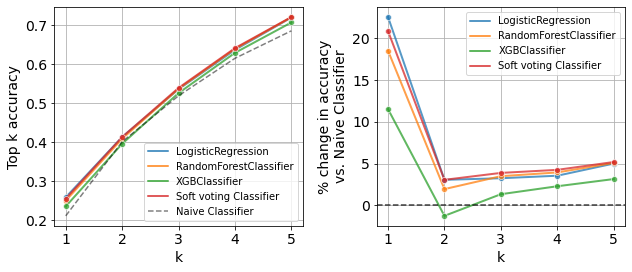

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(9,4))
sns.lineplot(x='k', y='topk_mod', hue='mod', marker='o', lw=2, data=res, alpha=0.75, ax=axs[0])
sns.lineplot(x='k', y='topk_naive', data=res[['k', 'topk_naive']].drop_duplicates(), color='k', ls='--', alpha=0.5, label='Naive Classifier', ax=axs[0])
sns.lineplot(x='k', y='pc', hue='mod', marker='o', data=res, lw=2, alpha=0.75, ax=axs[1])

axs[1].axhline(0, c='k', ls='--', alpha=0.75)
for ax in axs: 
  ax.set(xlabel='k')
  ax.legend(fontsize=10)
  ax.grid()

axs[0].set(ylabel='Top k accuracy')
axs[1].set(ylabel=f'% change in accuracy\nvs. Naive Classifier')
fig.tight_layout()
plt.show()

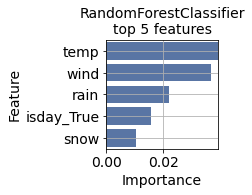

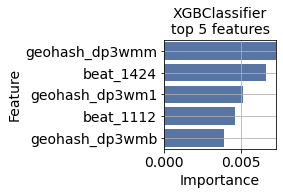

In [ ]:
# classifier feature importances
nnn = 5
for clf_name in ['rf', 'xgb']:
  fi_df = pd.DataFrame({'Feature':preprocessor.get_feature_names_out(), 'Importance':eclf.named_estimators_[clf_name].feature_importances_})
  fi_df['Feature'] = fi_df['Feature'].apply(lambda x: x.split('__')[1])
  fi_df = fi_df.nlargest(n=nnn, columns='Importance')

  # fig, ax = plt.subplots(figsize=(4,6))
  fig, ax = plt.subplots(figsize=(2,2))
  sns.barplot(x='Importance', y='Feature', data=fi_df, color='#4C72B0', ax=ax)
  maxval = fi_df['Importance'].abs().max()
  ax.set_xlim([None, maxval])
  ax.set_title(f'{eclf.named_estimators_[clf_name].__class__.__name__}\ntop {nnn} features' , fontsize=14)
  ax.grid()
  plt.show()

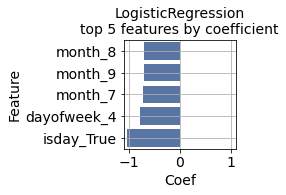

Features with zero coefficient: []


In [ ]:
# classifier coef
nnn = 5
class_num = 0
for clf_name in ['lr']:
  coef_df = pd.DataFrame({'Feature':preprocessor.get_feature_names_out(), 'Coef':eclf.named_estimators_[clf_name].coef_[class_num]})
  coef_df['Feature'] = coef_df['Feature'].apply(lambda x: x.split('__')[1])
  coef_df['abs_Coef'] = coef_df['Coef'].abs()
  coef_df = coef_df.nlargest(n=nnn, columns='abs_Coef')
  coef_df.sort_values('Coef', ascending=False, inplace=True)

  # fig, ax = plt.subplots(figsize=(4,6))
  fig, ax = plt.subplots(figsize=(2,2))
  sns.barplot(x='Coef', y='Feature', data=coef_df, color='#4C72B0', ax=ax)
  maxval = coef_df['Coef'].abs().max()*1.05
  ax.set_xlim([-maxval, maxval])
  ax.set_title(f'{eclf.named_estimators_[clf_name].__class__.__name__}\ntop {nnn} features by coefficient', fontsize=14)
  ax.grid()
  plt.show()

  coef_df = pd.DataFrame({'Feature':preprocessor.get_feature_names_out(), 'Coef':eclf.named_estimators_[clf_name].coef_[0]})
  coef_df['Feature'] = coef_df['Feature'].apply(lambda x: x.split('__')[1])
  print('Features with zero coefficient:', coef_df.loc[coef_df['Coef']==0, 'Feature'].tolist())

In [ ]:
# # tune individual models
# def tune(objective):
#   study = optuna.create_study(direction='maximize')
#   study.optimize(objective, n_trials=20)
#   params = study.best_params
#   best_score = study.best_value
#   print(f'Best score: {best_score} \nOptimized parameters: {params}')
#   return params

# def lr_objective(trial):
#   # _penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
#   _tol = trial.suggest_float('tol', 1e-5, 1e-1, log=True)
#   _C = trial.suggest_float('C', 0.1, 100.0, log=True)
#   # _class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
#   _intercept = trial.suggest_categorical('fit_intercept', [True, False])
#   # _solver = trial.suggest_categorical('solver', ['saga'])

#   lr = LogisticRegression(# penalty=_penalty,
#                           tol=_tol,
#                           C=_C,
#                           # class_weight=_class_weight,
#                           # solver=_solver,
#                           # max_iter=200,
#                           fit_intercept=_intercept,
#                           # solver=_solver,
#                           multi_class='auto',
#                           random_state=random_state,
#   )
  
#   lr.fit(X_train_enc, y_train_enc)
#   return lr.score(X_test_enc, y_test_enc)

# def rf_objective(trial):
#   _n_estimators = trial.suggest_int('n_estimators', 100, 500)
#   _max_depth = trial.suggest_int('max_depth', 5, 500)
#   _min_samp_split = trial.suggest_int('min_samples_split', 2, 10)
#   _min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#   _max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

#   rf = RandomForestClassifier(
#       n_estimators=_n_estimators,
#       max_depth=_max_depth,
#       min_samples_split=_min_samp_split,
#       min_samples_leaf=_min_samples_leaf,
#       max_features=_max_features,
#       n_jobs=-1,
#       random_state=random_state,
#   )
  
#   rf.fit(X_train_enc, y_train_enc)
#   return rf.score(X_test_enc, y_test_enc)

In [ ]:
# if 'rf_params' not in locals():
#   rf_params = tune(rf_objective)
# print('Optimized parameters:', rf_params)

# if 'lr_params' not in locals():
#   lr_params = tune(lr_objective)
# print('Optimized parameters:', lr_params)